In [2]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ltsfit.ltsfit import ltsfit


# Astropy imports
from astropy.table import Table

# Lenstronomy, HierArc imports
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
# from likelihoods_parallel import beta2theta_e_ratio, beta_double_source_plane
from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane, beta2theta_e_ratio
)

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

In [3]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,408649665972.69635,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,324309245490.47504,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,252718868917.48575,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,883777743495.4609,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,192914100798.88678,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,760108618473.295,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,462966940487.00793,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,176660221028.014,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,365843003536.67883,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20

In [4]:
r_band_magnitude_depths = [28, 26, 24, 22, 20, 18]

# number of lenses at each r-band magnitude depth
num_lenses = [len(GGL_data_table[(GGL_data_table['mag_D_r'] < depth) & (GGL_data_table['mag_S_r'] < depth)]) for depth in r_band_magnitude_depths]

print("Number of lenses at each r-band magnitude depth:")
for depth, count in zip(r_band_magnitude_depths, num_lenses):
    print(f"Depth < {depth}: {count} lenses")

Number of lenses at each r-band magnitude depth:
Depth < 28: 4880 lenses
Depth < 26: 1873 lenses
Depth < 24: 198 lenses
Depth < 22: 3 lenses
Depth < 20: 0 lenses
Depth < 18: 0 lenses


In [5]:
# apply magnitude cuts

GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
# GGL_data_table = Table.read(f"../data/fake_data_org_50.0v2.fits", format='fits')

# limits on the magnitudes for LSST 10 year survey ~ 26
LIMIT_BY_MAGNITUDE = True
LIMIT_BY_THETA_E = False
if LIMIT_BY_MAGNITUDE:
    mag_limits = {
        # "u": 26.1,
        # "i": 26.6,
        "r": 24,
        # "g": 27.4,
        # "z": 26.1,
        # "y": 24.9
    } # \citep{Bianco:2022}

    # filter the data table to only include galaxies with magnitudes less than the limits
    mask = np.ones(len(GGL_data_table), dtype=bool)
    for band, limit in mag_limits.items():
        mask &= GGL_data_table[f"mag_D_{band}"] < limit
        mask &= GGL_data_table[f"mag_S_{band}"] < limit
    new_GGL_data_table = GGL_data_table[mask]

    GGL_data_table = new_GGL_data_table

if LIMIT_BY_THETA_E:
    # filter the data table to only include galaxies with theta_E > 1.0 arcsec
    mask = GGL_data_table["theta_E"] > 1.0
    new_GGL_data_table = GGL_data_table[mask]

    GGL_data_table = new_GGL_data_table

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
37,1.063091965850194,3.3133948986183075,0.6422378675242981,215.44236009347333,322277743173.92865,23.278456244626653,23.370417932323498,23.632409828688218,23.195504135531074,23.132754151573778,22.626899617788546,23.25078233579365,23.673000738951927,21.828757737367013,21.339600869286024,0.47889333792064875,-0.006646459617250302,0.008317800398322677,0.010647123034419951,2,3.887620520607209,5996.416232924403,24.530610528020592
39,1.130864101101034,2.4737462863666946,1.134275026689338,322.9183491322652,999646415127.992,23.576442806454907,23.71480671114483,23.862106894709093,23.567157502028714,23.41917638220736,21.58580046078247,22.205400389423094,22.56462814991499,20.88457913641849,20.33799886948523,0.9012420638637695,0.23080791533764264,0.08331727221335093,0.24538553672044738,2,7.403218850636128,6519.055659901237,24.805473097099902
57,0.3745408747440537,1.9648541319876067,0.948849766495961,214.53599496102223,319552611156.18695,23.10054185701933,23.141501498218126,23.29427805278418,22.922744058052608,22.790476474082297,18.640632371605207,19.151201884804777,20.41903073948069,18.32296642803722,18.174963620961215,1.2935806578743785,-0.019997969388200455,-0.010288248026473238,0.0224892602614144,2,6.672992037516773,1968.28857428955,23.46212355923083
82,0.08735512547649388,0.5971974632236927,0.687975434202141,169.2085871745265,145081577072.50406,22.439457803688885,23.15087568953778,24.03346866342886,22.182589191486226,21.9688742062577,15.875831404338822,16.26749545424725,17.086575998506508,15.619552939728532,15.468015497746624,1.0283639136797138,0.00040200399439713143,-0.0008182404725643246,0.0009116603986427941,2,1.6810956292235513,1937.715992226131,19.609325277110152
100,0.23074491088722293,1.4071222674920374,0.7649091329217595,184.7857472811958,199137393622.6551,21.326920051098924,21.591483214619842,21.761851073627156,21.165344493816313,20.764156753044823,17.85931038571798,18.324949768743526,19.462281875474797,17.635051398687242,17.43477457162683,0.919419427805336,0.0028001618733005658,-0.001391095593048136,0.0031266681092952733,2,3.386484528259163,2039.274601830494,21.738739736151423
104,0.6715056515192871,1.2512825715009508,0.9911299157788354,302.8857169817819,816953386459.9016,22.04053043535706,22.518918078410774,23.043327277704503,21.45354761680463,21.00898785987002,19.657571510612524,20.75063220874313,21.840736587958784,19.211148609647704,18.89078356108558,0.7604467385540495,0.16029318890903266,-0.014475604406789539,0.1609454862168203,2,5.342580505635573,6649.213804424573,23.70704665608565
206,0.47158720612716626,1.7820937737035378,1.2696877285991222,264.3884851139923,560633573959.3396,22.921266834904202,22.996096388873816,23.13036194458099,22.809643834076944,22.740470853362844,18.68475807649451,19.37008651138178,20.765661458241674,18.32948443031505,18.053811998429453,0.8844231293273657,0.1451418859738898,-0.08229269752736225,0.16684800007907666,2,5.229716757351839,4300.218963017572,22.983697816444327
207,1.1200470087175265,2.714661150147523,0.5881767606424234,223.32577331110542,357679911199.3965,23.57229117848255,23.668362761681763,23.689243807832092,23.572469628794934,23.576196635473842,22.95517609403426,23.946433671645753,24.990904605730858,22.08292410266561,21.463757778817875,0.41510519475428387,0.010142919455955973,-0.022212238437908555,0.02441848380863383,2,3.4040235156098047,6918.87014288542,25.53656433344283
240,0.6279140913937816,2.3342752878288584,0.985624359505243,240.10630943181806,435928465454.31323,23.096439624996766,23.24679656272932,23.45900409615577,22.969349741195646,22.747714890092293,20.075936488977415,21.2

In [6]:
# fit the FP
coeffs_FP = fit_plane(
    np.log10(GGL_data_table["R_e_kpc"]),
    GGL_data_table['surf_bri_mag/arcsec2'],
    np.log10(GGL_data_table["sigma_v_D"])
)

# find the scatter
scatter_FP = find_scatter(
    np.log10(GGL_data_table["R_e_kpc"]),
    GGL_data_table['surf_bri_mag/arcsec2'],
    np.log10(GGL_data_table["sigma_v_D"]),
    coeffs_FP,
    return_fit=False
)

coeffs_FP_alt = fit_plane(
    np.log10(GGL_data_table["sigma_v_D"]),
    GGL_data_table['surf_bri_mag/arcsec2'],
    np.log10(GGL_data_table["R_e_kpc"]),
)

scatter_FP_alt = find_scatter(
    np.log10(GGL_data_table["sigma_v_D"]),
    GGL_data_table['surf_bri_mag/arcsec2'],
    np.log10(GGL_data_table["R_e_kpc"]),
    coeffs_FP_alt,
    return_fit=False
)

display(Markdown(f"SLSim FP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_FP[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_FP[1]:.2f} * "+"$\\mu_e + "+f"{coeffs_FP[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_FP):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_FP)*np.log(10)*100:.2f} %"))
display(Markdown(f"SLSim FP (alt): "+"$\\log_{10}(R_e)$ = " + f"{coeffs_FP_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_FP_alt[1]:.2f} * "+"$\\mu_e + "+f"{coeffs_FP_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_FP_alt):.2f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_FP_alt)*np.log(10)*100:.2f} %"))

SLSim FP: $\log_{10}(\sigma_v)$ = 0.34 * $\log_{10}(R_e)$ + 0.01 * $\mu_e + 1.97$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.06 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 13.47 %

SLSim FP (alt): $\log_{10}(R_e)$ = 1.16 * $\log_{10}(\sigma_v)$ + 0.04 * $\mu_e + -3.13$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.11 dex $\Rightarrow {\Delta R_e}/{R_e}$: 24.92 %

sig_int:     0.0000  46975708234.4521
Computing sig_int
sig_int:     0.0000  46975708234.6631
sig_int:     0.3471     -0.9744
sig_int:     0.3470     -0.9744
sig_int:     0.1735     -0.8977
sig_int:     0.0867     -0.5906
sig_int:     0.0434      0.6375
sig_int:     0.0659     -0.2904
sig_int:     0.0520      0.1381
sig_int:     0.0565     -0.0348
sig_int:     0.0556     -0.0033
sig_int:     0.0555      0.0000
sig_int:     0.0555     -0.0010
Computing sig_int error
sig_int:     0.0555      0.1023
sig_int:     0.3471     -0.8721
sig_int:     0.0861     -0.4824
sig_int:     0.0609     -0.0661
sig_int:     0.0588     -0.0055
sig_int:     0.0586      0.0000
sig_int:     0.0586     -0.0009
Repeating at best fitting solution
sig_int:     0.0555      0.0000

################# Values and formal errors ################

        a =  1.65 +/- 0.23
      b_0 =  0.352 +/- 0.028
      b_1 =  0.36 +/- 0.17
  scatter =  0.0555 +/- 0.0031
Observed rms scatter: 0.0555
y = a + (x_0 - p_0) b_0 + (x_1 - p

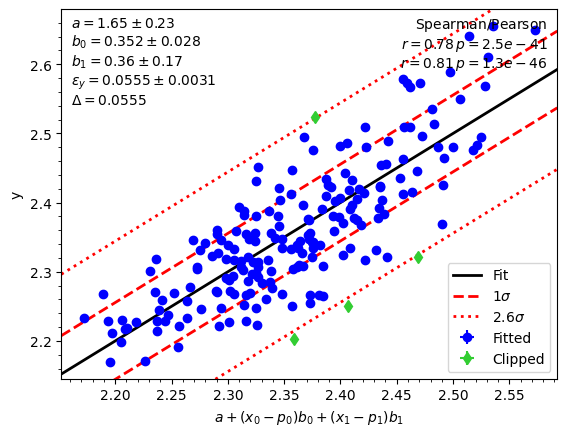

In [7]:
x1 = np.log10(GGL_data_table["R_e_kpc"])
x2 = np.log10(GGL_data_table["surf_bri_mag/arcsec2"])
y = np.log10(GGL_data_table["sigma_v_D"])

#arrays
x1, x2, y = np.array(x1), np.array(x2), np.array(y)

x = np.column_stack([x1, x2])
sigx = np.ones_like(x)*0.0000001
sigy = np.ones_like(y)*0.0000001  # Example uncertainty for y

p = ltsfit(x, y, sigx, sigy, corr=True, epsy=True, clip = 2.6,
           frac=None, label='Fitted',
           legend=True,plot=True, text=True)

print(f"Best fitting parameters: {p.coef}")
print(f"Scatter in log sigma_v: {p.sig_int} dex")
print(f"Scatter in sigma_v: {p.sig_int*np.log(10)*100:.2f} %")


In [10]:
# make bins on the R_e vs Sigma_half plane and make pairings
# then compute the scatter in sigma_v_D from pairings
# and also the scatter in beta_E from pairings

num_bins = 20  # number of bins


# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# binned statistics
binned_statistics = {
    'num_pairs': np.zeros((num_bins - 1, num_bins - 1)),
    'rel_scatter_beta_E': np.ones((num_bins - 1, num_bins - 1))*np.nan,
    'rel_scatter_sigma_v_D': np.ones((num_bins - 1, num_bins - 1))*np.nan,
}
THRESHOLD_DELTA_Z = 0.01  # threshold for delta_z to consider a pair valid

# store pairing data template 
individual_pair_data = {
    'beta_E_pseudo': [],
    'beta_E_DSPL': [],
    'z_D1': [],
    'z_D2': [],
    'z_S1': [],
    'z_S2': [],
    'sigma_v_D1': [],
    'sigma_v_D2': [],
    'lens1_id': [],
    'lens2_id': [],
}

# make bins on the R_e vs Sigma_half plane
x = np.log10(GGL_data_table["R_e_kpc"])
y = np.log10(GGL_data_table["surf_bri_mag/arcsec2"])

x_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
y_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)

# make pairings
for i in tqdm(range(len(x_bins) - 1)):
    for j in range(len(y_bins) - 1):
        mask = (
            (x >= x_bins[i]) & (x < x_bins[i + 1]) &
            (y >= y_bins[j]) & (y < y_bins[j + 1])
        )
        if np.sum(mask) < 2:
            continue
        
        # get the data points in this bin
        data_points = GGL_data_table[mask]
        
        curr_bin_sig_v_D1s = []
        curr_bin_sig_v_D2s = []
        curr_bin_beta_E_pseudos = []
        curr_bin_beta_E_DSPLs = []
        curr_bin_num_pairs = 0


        # make pairings
        for lens1, lens2 in combinations(data_points, 2):
            beta_E_pseudo = lens1['theta_E'] / lens2['theta_E']

            # check z_lens < z_source
            if lens1['z_D'] >= lens2['z_S'] or lens2['z_D'] >= lens1['z_S']:
                continue

            beta_DSPL = beta_double_source_plane(
                z_lens = np.mean([lens1['z_D'], lens2['z_D']]),
                z_source_1= lens1['z_S'],
                z_source_2= lens2['z_S'],
                cosmo = cosmo_true,
            )
            beta_E_DSPL = beta2theta_e_ratio(
                beta_dsp= beta_DSPL,
                gamma_pl= 2, #TODO: what if gamma_pl != 2?
                lambda_mst= 1
            )

            individual_pair_data['beta_E_pseudo'].append(beta_E_pseudo)
            individual_pair_data['beta_E_DSPL'].append(beta_E_DSPL)
            individual_pair_data['z_D1'].append(lens1['z_D'])
            individual_pair_data['z_D2'].append(lens2['z_D'])
            individual_pair_data['z_S1'].append(lens1['z_S'])
            individual_pair_data['z_S2'].append(lens2['z_S'])
            individual_pair_data['sigma_v_D1'].append(lens1['sigma_v_D'])
            individual_pair_data['sigma_v_D2'].append(lens2['sigma_v_D'])
            individual_pair_data['lens1_id'].append(lens1['lens_id'])
            individual_pair_data['lens2_id'].append(lens2['lens_id'])

            if 2*np.abs(lens1['z_D'] - lens2['z_D'])/(lens1['z_D'] + lens2['z_D']) <= THRESHOLD_DELTA_Z:
                curr_bin_sig_v_D1s.append(lens1['sigma_v_D'])
                curr_bin_sig_v_D2s.append(lens2['sigma_v_D'])
                curr_bin_beta_E_pseudos.append(beta_E_pseudo)
                curr_bin_beta_E_DSPLs.append(beta_E_DSPL)
                curr_bin_num_pairs += 1
        
        # make numpy arrays
        curr_bin_sig_v_D1s = np.array(curr_bin_sig_v_D1s)
        curr_bin_sig_v_D2s = np.array(curr_bin_sig_v_D2s)
        curr_bin_beta_E_pseudos = np.array(curr_bin_beta_E_pseudos)
        curr_bin_beta_E_DSPLs = np.array(curr_bin_beta_E_DSPLs)

        # compute the relative scatter in beta_E and sigma_v_D
        if len(curr_bin_sig_v_D1s) > 0 and len(curr_bin_sig_v_D2s) > 0:
            # relative scatter in beta_E
            rel_scatter_beta_E = np.std(1 - curr_bin_beta_E_pseudos/curr_bin_beta_E_DSPLs)
            binned_statistics['rel_scatter_beta_E'][i, j] = rel_scatter_beta_E

            # relative scatter in sigma_v_D
            rel_scatter_sigma_v_D = 2 * np.std(curr_bin_sig_v_D1s - curr_bin_sig_v_D2s)/ np.mean(curr_bin_sig_v_D1s + curr_bin_sig_v_D2s)
            binned_statistics['rel_scatter_sigma_v_D'][i, j] = rel_scatter_sigma_v_D

            # update the number of pairs in this bin
            binned_statistics['num_pairs'][i, j] = curr_bin_num_pairs

# convert to astropy tables
individual_pair_data_table = Table(individual_pair_data)

individual_pair_data_table

  0%|          | 0/19 [00:00<?, ?it/s]/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_92875/4128789785.py:74: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta_DSPL = beta_double_source_plane(
100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


beta_E_pseudo,beta_E_DSPL,z_D1,z_D2,z_S1,z_S2,sigma_v_D1,sigma_v_D2,lens1_id,lens2_id
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
0.8934850026359854,1.1234834340542355,0.3508366197875022,0.3620911023550497,3.5838671355393195,1.7526678621306748,149.81556404690141,168.79967282267145,663,1418
0.8048168142112336,1.0111262139766422,0.3508366197875022,0.2846013599191938,3.5838671355393195,3.201849663926679,149.81556404690141,164.24668357195608,663,3012
0.9007614138310545,0.9118133772707815,0.3620911023550497,0.2846013599191938,1.7526678621306748,3.201849663926679,168.79967282267145,164.24668357195608,1418,3012
0.8057354374232187,0.9949185424866146,0.10787290407230968,0.11481755505949663,1.0645867809323561,1.1155260007130066,141.52093069960833,157.9885526264794,2901,3094
0.8136147379454665,0.9331420353088881,0.10787290407230968,0.11963325158125679,1.0645867809323561,2.9363488978002947,141.52093069960833,152.4781458972197,2901,3569
1.009779016977888,0.9360309186611583,0.11481755505949663,0.11963325158125679,1.1155260007130066,2.9363488978002947,157.9885526264794,152.4781458972197,3094,3569
0.9677714932843753,1.0267016536333284,0.11452865256521456,0.17487583904282808,4.6151024398779095,2.4818117354825984,141.29420849032388,148.51115820717058,576,584
1.0079807437358443,1.0382507325311412,0.11452865256521456,0.18518917904055898,4.6151024398779095,2.1227477778683728,141.29420849032388,147.0417676560034,576,826
0.9719313518868414,1.0088873694674523,0.11452865256521456,0.244290702517287,4.6151024398779095,3.7502940843059163,141.29420849032388,149.6833354785437,576,2274


In [11]:
# print the scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01
print(f"================= Sky Area: {sky_area} sq. deg. =================")
mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
print(f"# of pairs with |Δz/z| < 0.01: {np.sum(mask)}")
sigma_v_scatter = np.std(individual_pair_data_table[mask]['sigma_v_D1'] - individual_pair_data_table[mask]['sigma_v_D2']) / (np.mean(individual_pair_data_table[mask]['sigma_v_D1'] + individual_pair_data_table[mask]['sigma_v_D2']) / 2)
print(f"Relative scatter in σᵥ: {sigma_v_scatter:.3f}")

# scatter in beta_E
beta_E_scatter = np.std(1 - individual_pair_data_table[mask]['beta_E_pseudo']/individual_pair_data_table[mask]['beta_E_DSPL'])
print(f"Relative scatter in β_E: {beta_E_scatter:.3f}")
print()  # for better readability

================= Sky Area: 50.0v2 sq. deg. =================
# of pairs with |Δz/z| < 0.01: 6927
Relative scatter in σᵥ: 0.150
Relative scatter in β_E: 0.298



Text(0, 0.5, '$\\Delta \\sigma_v / \\sigma_v$ of FP (%)')

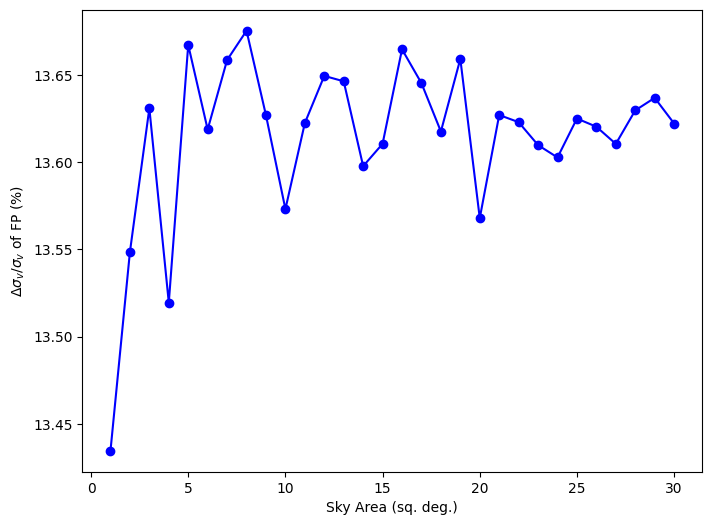

In [ ]:
# scatter in sigma_v_D on FP vs sky area

areas = np.arange(1, 31)  # sky areas from 1 to 30 sq. deg.
sigma_v_scatter_FP = []
for area in areas:
    # randomly sample scaled number of lenses
    num_lenses = (area/int(sky_area.split('.')[0])) * len(GGL_data_table)
    num_lenses = int(num_lenses)  # ensure it's an integer
    
    sigma_v_scatter = 0
    for _ in range(100):  # repeat the sampling 100 times to get a better estimate
        # sample the data points
        sampled_data = GGL_data_table[np.random.choice(len(GGL_data_table), num_lenses, replace=False)]
        # fit the FP
        coeffs_FP = fit_plane(
            np.log10(sampled_data["R_e_kpc"]),
            np.log10(sampled_data["surf_bri_mag/arcsec2"]),
            np.log10(sampled_data["sigma_v_D"])
        )
        # find the scatter
        scatter_FP_ = find_scatter(
            np.log10(sampled_data["R_e_kpc"]),
            np.log10(sampled_data["surf_bri_mag/arcsec2"]),
            np.log10(sampled_data["sigma_v_D"]),
            coeffs_FP,
            return_fit=False
        )
        # compute the relative scatter
        sigma_v_scatter += np.std(scatter_FP_) * np.log(10)

    sigma_v_scatter /= 100  # average over 100 samples
    sigma_v_scatter_FP.append(sigma_v_scatter)

sigma_v_scatter_FP = np.array(sigma_v_scatter_FP)

# plot the scatter in sigma_v_D vs sky area
plt.figure(figsize=(8, 6))
plt.plot(areas, sigma_v_scatter_FP*100, marker='o', linestyle='-',
         color='blue', label='σᵥ scatter on FP')
plt.xlabel('Sky Area (sq. deg.)')
plt.ylabel('$\\Delta \\sigma_v / \\sigma_v$ of FP (%)')

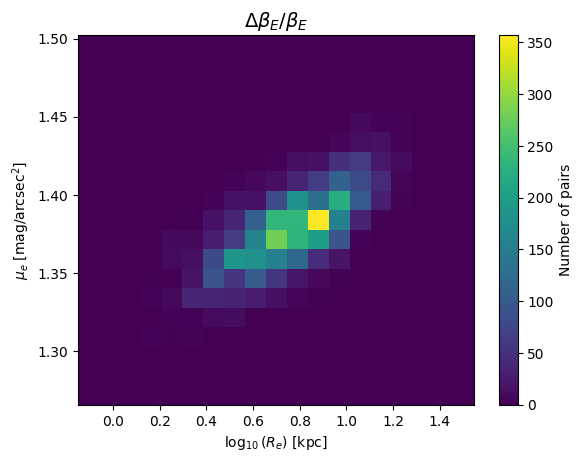

In [16]:
# number of pairs within bins
plt.figure()
# Second plot: binned_statistics['rel_scatter_beta_E']
im2 = plt.imshow(binned_statistics['num_pairs'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
plt.xlabel('$\\log_{10}(R_e)$ [kpc]')
plt.ylabel('$\\mu_e$ [mag/arcsec$^2$]')
plt.title('${\\Delta \\beta_E}/{\\beta_E}$', fontsize= 14)

plt.colorbar(im2, label='Number of pairs')

## Plots for Paper

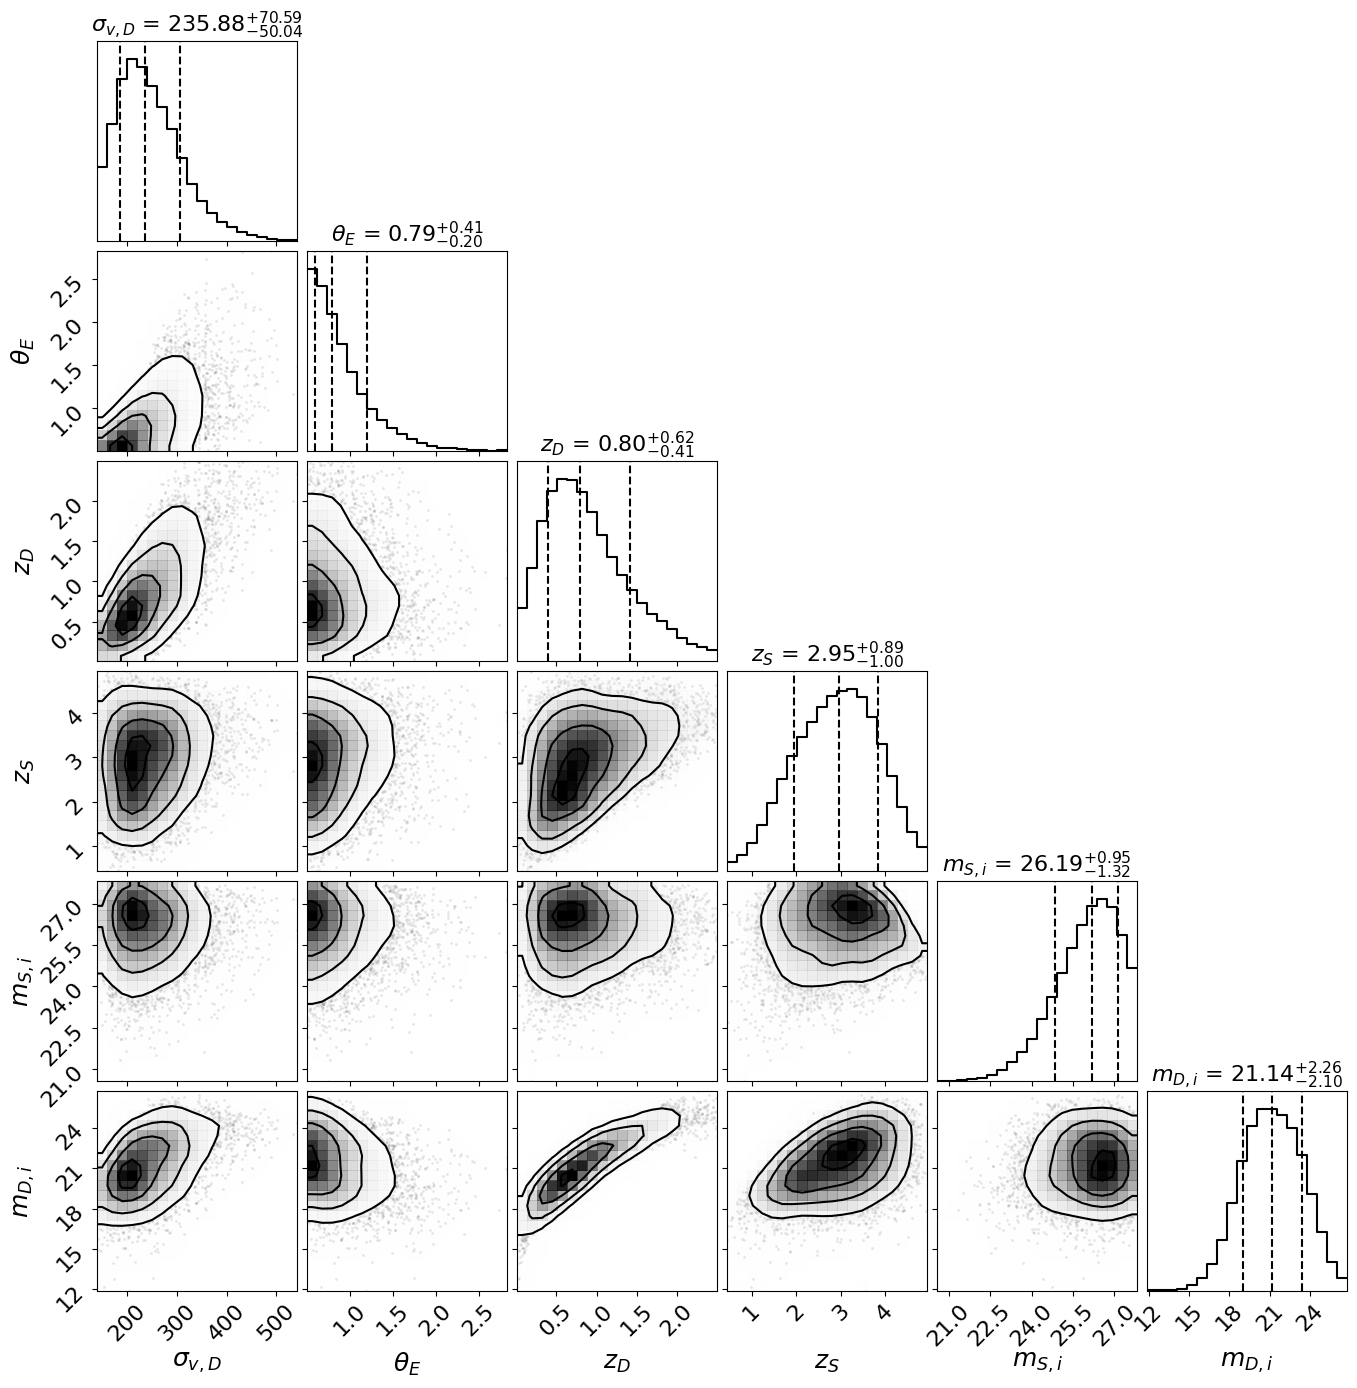

In [17]:
### Corner plot of lens properties

keys = [
    'sigma_v_D',
    'theta_E',
    'z_D',
    'z_S',
    'mag_S_i',
    'mag_D_i',
    # 'e_mass_D',
]

latex_keys = [
    r"$\sigma_{v,D}$",
    r"$\theta_{E}$",
    r"$z_{D}$",
    r"$z_{S}$",
    r"$m_{S,i}$",
    r"$m_{D,i}$",
    # r"$\varepsilon_{D}$",
]

corner_data = GGL_data_table[keys]
corner_data = np.array([corner_data[key] for key in keys]).T

# make a corner plot
fig = corner.corner(
    corner_data,
    labels=latex_keys,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    smooth=True,
    smooth1d=True,
)

# make tick and label sizes larger
for ax in fig.get_axes():
    ax.tick_params(labelsize=16)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

    # make title font size larger
    ax.title.set_fontsize(16)

# save the figure
# fig.savefig(f"../figures/slsim_corner_GGL.pdf", bbox_inches='tight', dpi=300)

(0.2, 1.3)

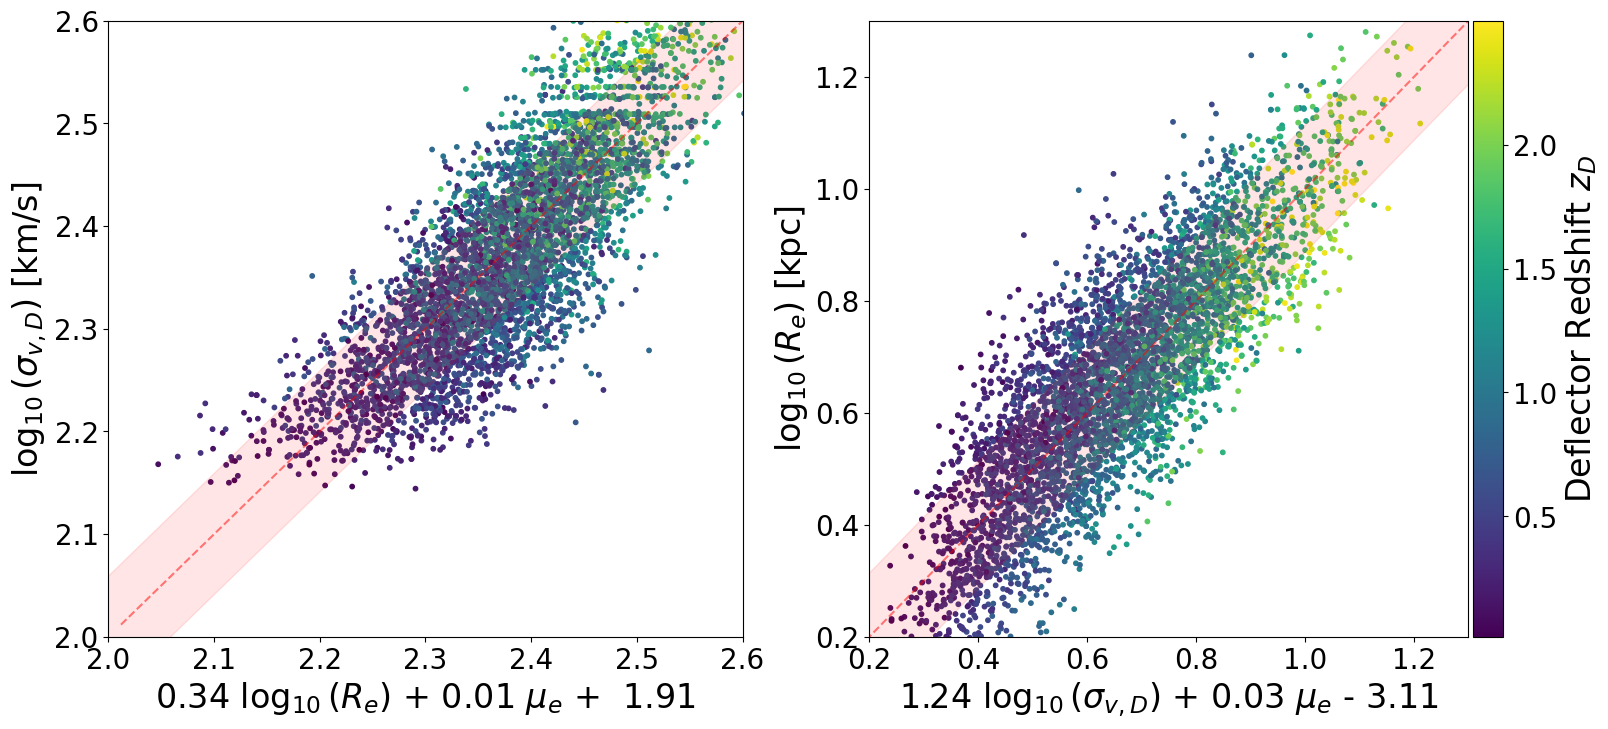

In [31]:
## FP plot

# side-by-side plot of the two fundamental planes
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sigma_v fundamental plane
axs[0].scatter(
    coeffs_FP[0] * np.log10(GGL_data_table["R_e_kpc"]) + 
    coeffs_FP[1] * (GGL_data_table["surf_bri_mag/arcsec2"]) + 
    coeffs_FP[2],
    np.log10(GGL_data_table["sigma_v_D"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim FP', 
    cmap='viridis'
)
axs[0].set_xlabel(f'{coeffs_FP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_FP[1]:.2f} ' + r'$\mu_e$ + ' + f' {coeffs_FP[2]:.2f}')
axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
# axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

# Plot the fitted plane with a faded scatter
# y = x
axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
y_faded = x_faded
axs[0].fill_between(x_faded, y_faded - np.std(scatter_FP),
                    y_faded + np.std(scatter_FP), color='red', alpha=0.1)

# R_e fundamental plane
scatter_plot = axs[1].scatter(
    coeffs_FP_alt[0] * np.log10(GGL_data_table["sigma_v_D"]) + 
    coeffs_FP_alt[1] * (GGL_data_table["surf_bri_mag/arcsec2"]) + 
    coeffs_FP_alt[2],
    np.log10(GGL_data_table["R_e_kpc"]),
    c=GGL_data_table["z_D"], s=10, label='SLSim FP', 
    cmap='viridis'
)
axs[1].set_xlabel(f'{coeffs_FP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_FP_alt[1] > 0 else '-'} {np.abs(coeffs_FP_alt[1]):.2f} ' + r'$\mu_e$ ' + f'{'+' if coeffs_FP_alt[2] > 0 else '-'} {np.abs(coeffs_FP_alt[2]):.2f}')
axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
# axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
# Plot the fitted plane with a faded scatter
# y = x
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
y_faded = x_faded
axs[1].fill_between(x_faded, y_faded - np.std(scatter_FP_alt),
                    y_faded + np.std(scatter_FP_alt), color='red', alpha=0.1)

# common colorbar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatter_plot, cax=cax)
cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


# increase the font size of the labels and title
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=24)
    ax.set_ylabel(ax.get_ylabel(), fontsize=24)
    ax.set_title(ax.get_title(), fontsize=24)
    # ax.legend(fontsize=14)

# cbar label size
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

# cbar tick labels
cbar.ax.tick_params(labelsize=20)

axs[0].set_xlim(2, 2.6)
axs[0].set_ylim(2, 2.6)
axs[1].set_xlim(0.2, 1.3)
axs[1].set_ylim(0.2, 1.3)

# save the figure
# fig.savefig(f"../figures/slsim_FP.pdf", bbox_inches='tight', dpi=300)

Correlation Coefficient: 0.99, Slope: 2.09, Intercept: -0.00, Standard Error: 0.03

Percentage scatter in y: 9.81%

95% Confidence Interval for the Slope: [2.04, 2.15]

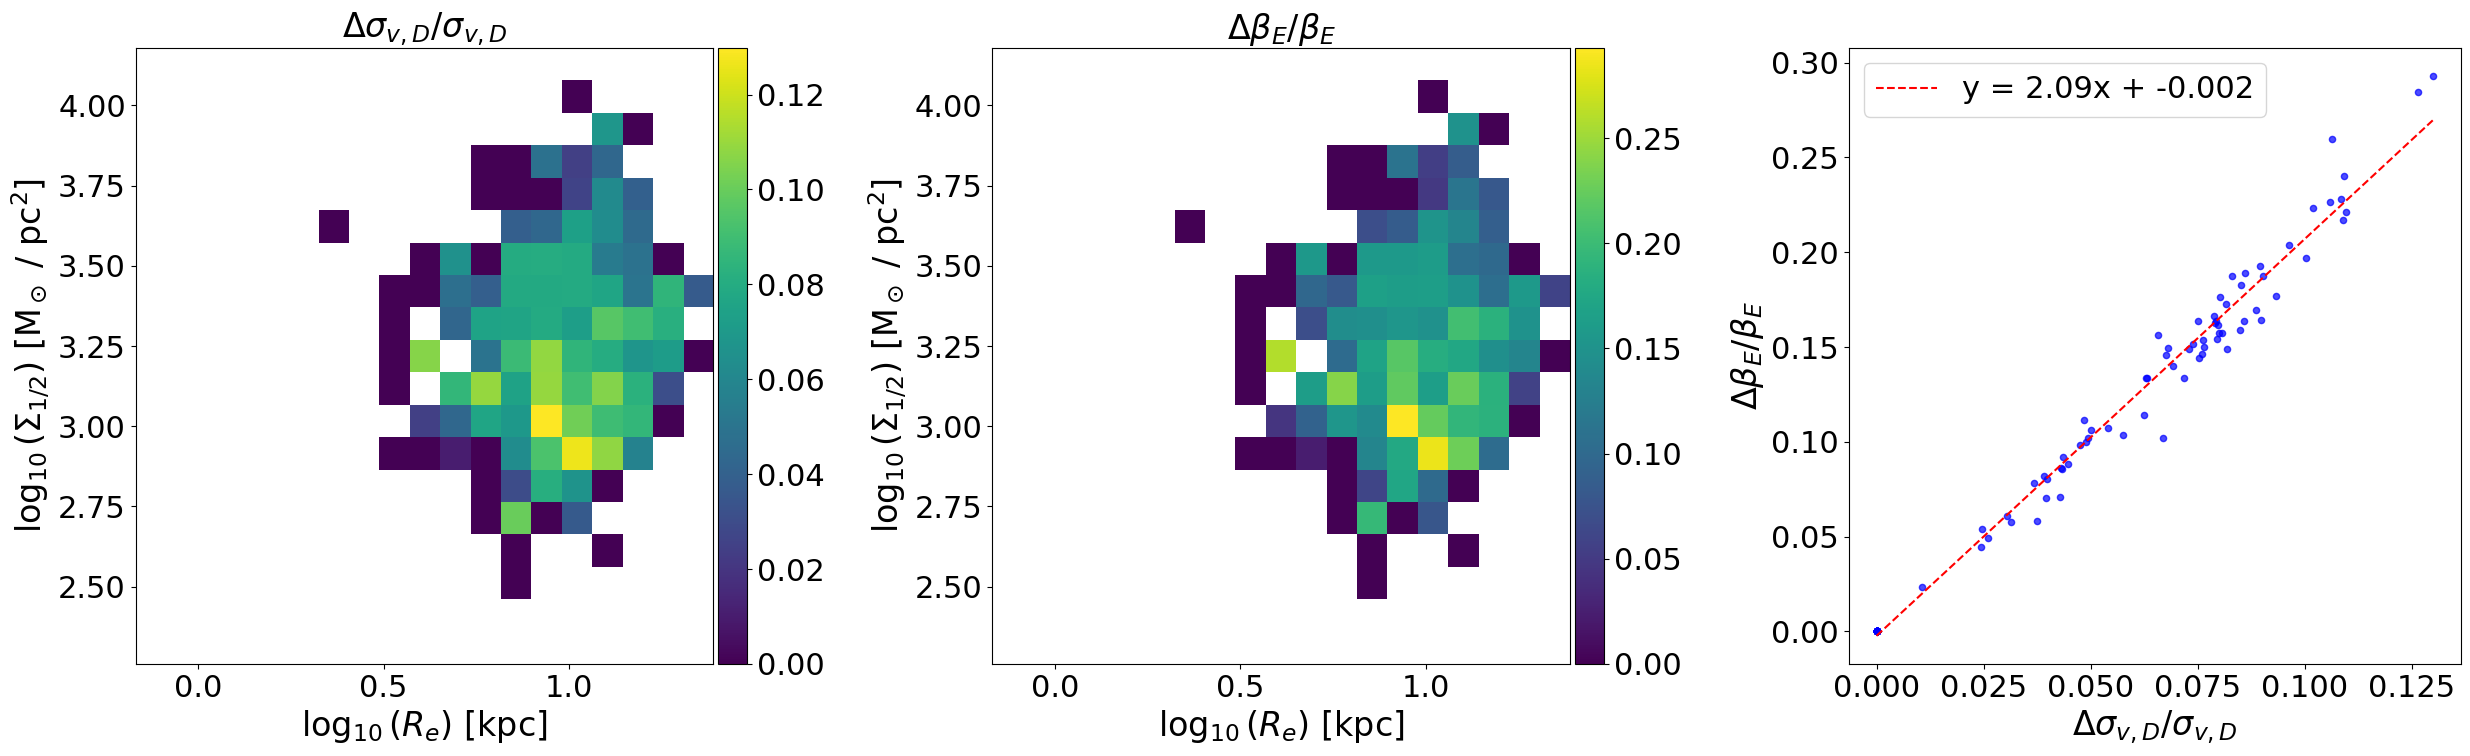

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

base_fontsize = 22

x_label = r'$\log_{10}(R_e)$ [kpc]'
y_label = r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$ / pc$^2$]'

# First plot: binned_statistics['rel_scatter_sigma_v_D']
im1 = axs[0].imshow(binned_statistics['rel_scatter_sigma_v_D'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: binned_statistics['rel_scatter_beta_E']
im2 = axs[1].imshow(binned_statistics['rel_scatter_beta_E'], origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(binned_statistics['rel_scatter_sigma_v_D'].flatten(),
    binned_statistics['rel_scatter_beta_E'].flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = binned_statistics['rel_scatter_sigma_v_D'].flatten()
y_scatter = binned_statistics['rel_scatter_beta_E'].flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+2)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+2)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+2)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)

# Save the figure
# fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))
display(Markdown(f"Percentage scatter in y: {np.std(y_scatter - (slope * x_scatter + intercept)) / np.mean(y_scatter) * 100:.2f}%"))


# 95% confidence interval for the slope
from scipy.stats import t
n = len(x_scatter)  # number of data points
alpha = 0.05  # significance level for 95% confidence interval
t_critical = t.ppf(1 - alpha/2, n - 2)
margin_of_error = t_critical * std_err
lower_bound = slope - margin_of_error
upper_bound = slope + margin_of_error
display(Markdown(f"95% Confidence Interval for the Slope: [{lower_bound:.2f}, {upper_bound:.2f}]"))

Correlation Coefficient: 0.96, Slope: 2.26, Intercept: -0.02, Standard Error: 0.07

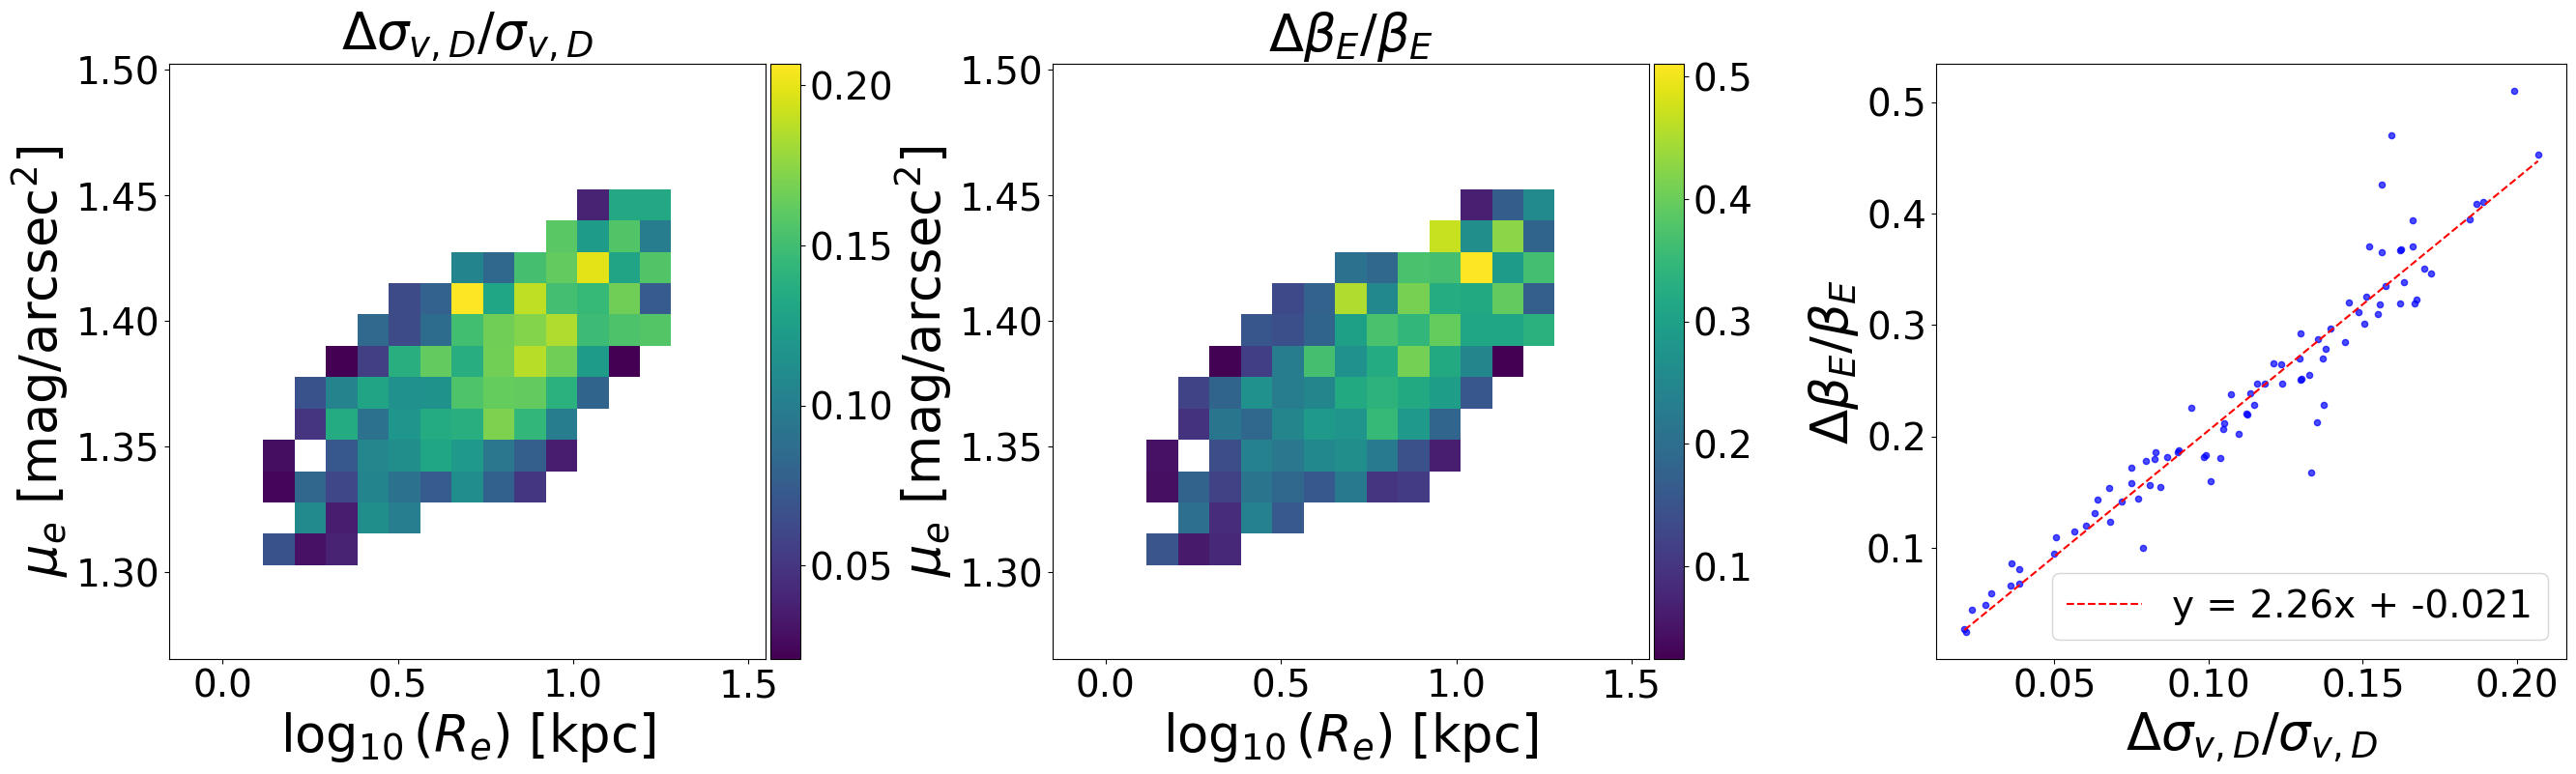

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(32, 8))

base_fontsize = 28

x_label = r'$\log_{10}(R_e)$ [kpc]'
y_label = r'$\mu_e$ [mag/arcsec$^2$]'

mask = binned_statistics['num_pairs'] > 1

# First plot: rel_scatter_sigma_v_D
rel_scatter_sigma_v_D = binned_statistics['rel_scatter_sigma_v_D'].copy()
rel_scatter_sigma_v_D[~mask] = np.nan  # set to NaN

# Second plot: rel_scatter_beta_E
rel_scatter_beta_E = binned_statistics['rel_scatter_beta_E'].copy()
rel_scatter_beta_E[~mask] = np.nan  # set to NaN



# First plot: rel_scatter_sigma_v_D
im1 = axs[0].imshow(rel_scatter_sigma_v_D, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: rel_scatter_beta_E
im2 = axs[1].imshow(rel_scatter_beta_E, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(x_bins), np.nanmax(x_bins),
    np.nanmin(y_bins), np.nanmax(y_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(rel_scatter_sigma_v_D.flatten(),
    rel_scatter_beta_E.flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = rel_scatter_sigma_v_D.flatten()
y_scatter = rel_scatter_beta_E.flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+10)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+10)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+10)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)
# fig.tight_layout()

# Save the figure
# fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))


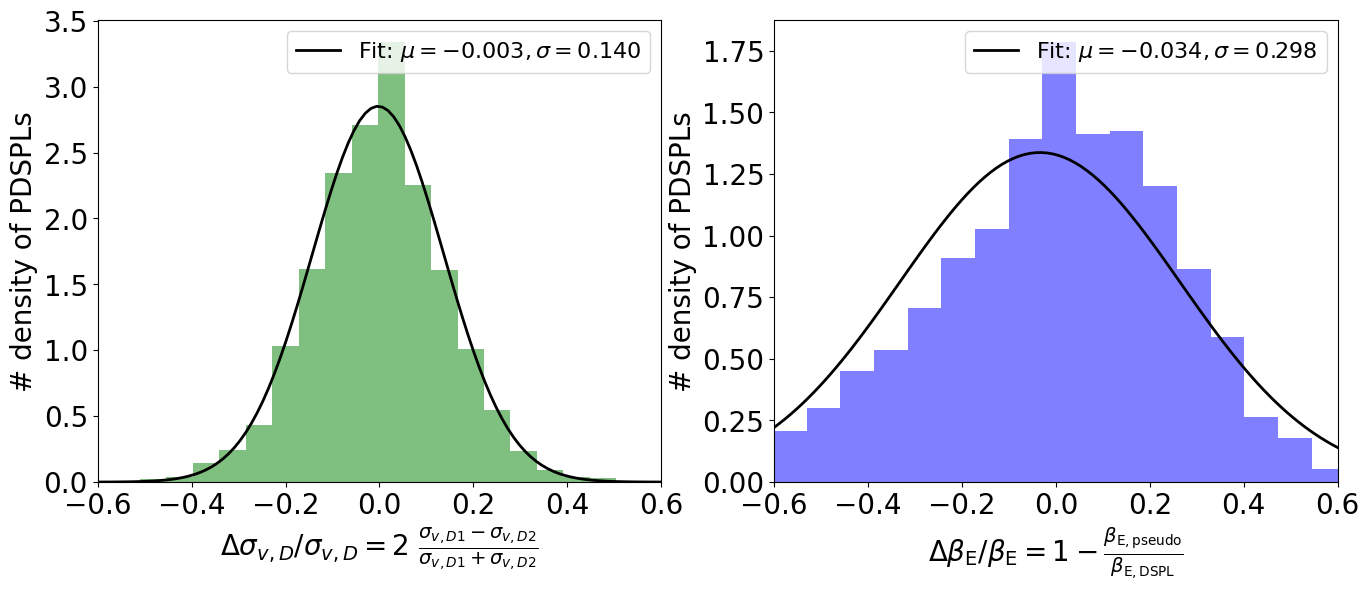

In [24]:
# histogram of the relative scatter in beta_E and sigma_v_D
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

masked_paired_table = individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) <= THRESHOLD_DELTA_Z
]

# First histogram: relative scatter in sigma_v_D
axs[0].hist(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2']),
    bins=20, color='green', alpha=0.5, density=True
)
axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[0].set_title('Histogram of Relative Scatter in $\\sigma_{v,D}$', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
from scipy.stats import norm
mu, std = norm.fit(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2'])
)
x = np.linspace(-0.6, 0.6, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
axs[0].legend(fontsize=14)

# Second histogram: relative scatter in beta_E
axs[1].hist(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'], bins=40, 
            color='blue', alpha=0.5, density=True)
axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
# axs[1].set_title('Histogram of Relative Scatter in $\\beta_E$', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu_beta, std_beta = norm.fit(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'])
x_beta = np.linspace(-0.6, 0.6, 100)
p_beta = norm.pdf(x_beta, mu_beta, std_beta)
axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
axs[1].legend(fontsize=14)

# fig.tight_layout()


# change tick and label sizes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    # make title font size larger
    ax.title.set_fontsize(20)

    # legend font size
    if ax.get_legend() is not None:
        ax.legend(fontsize=16)



# fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

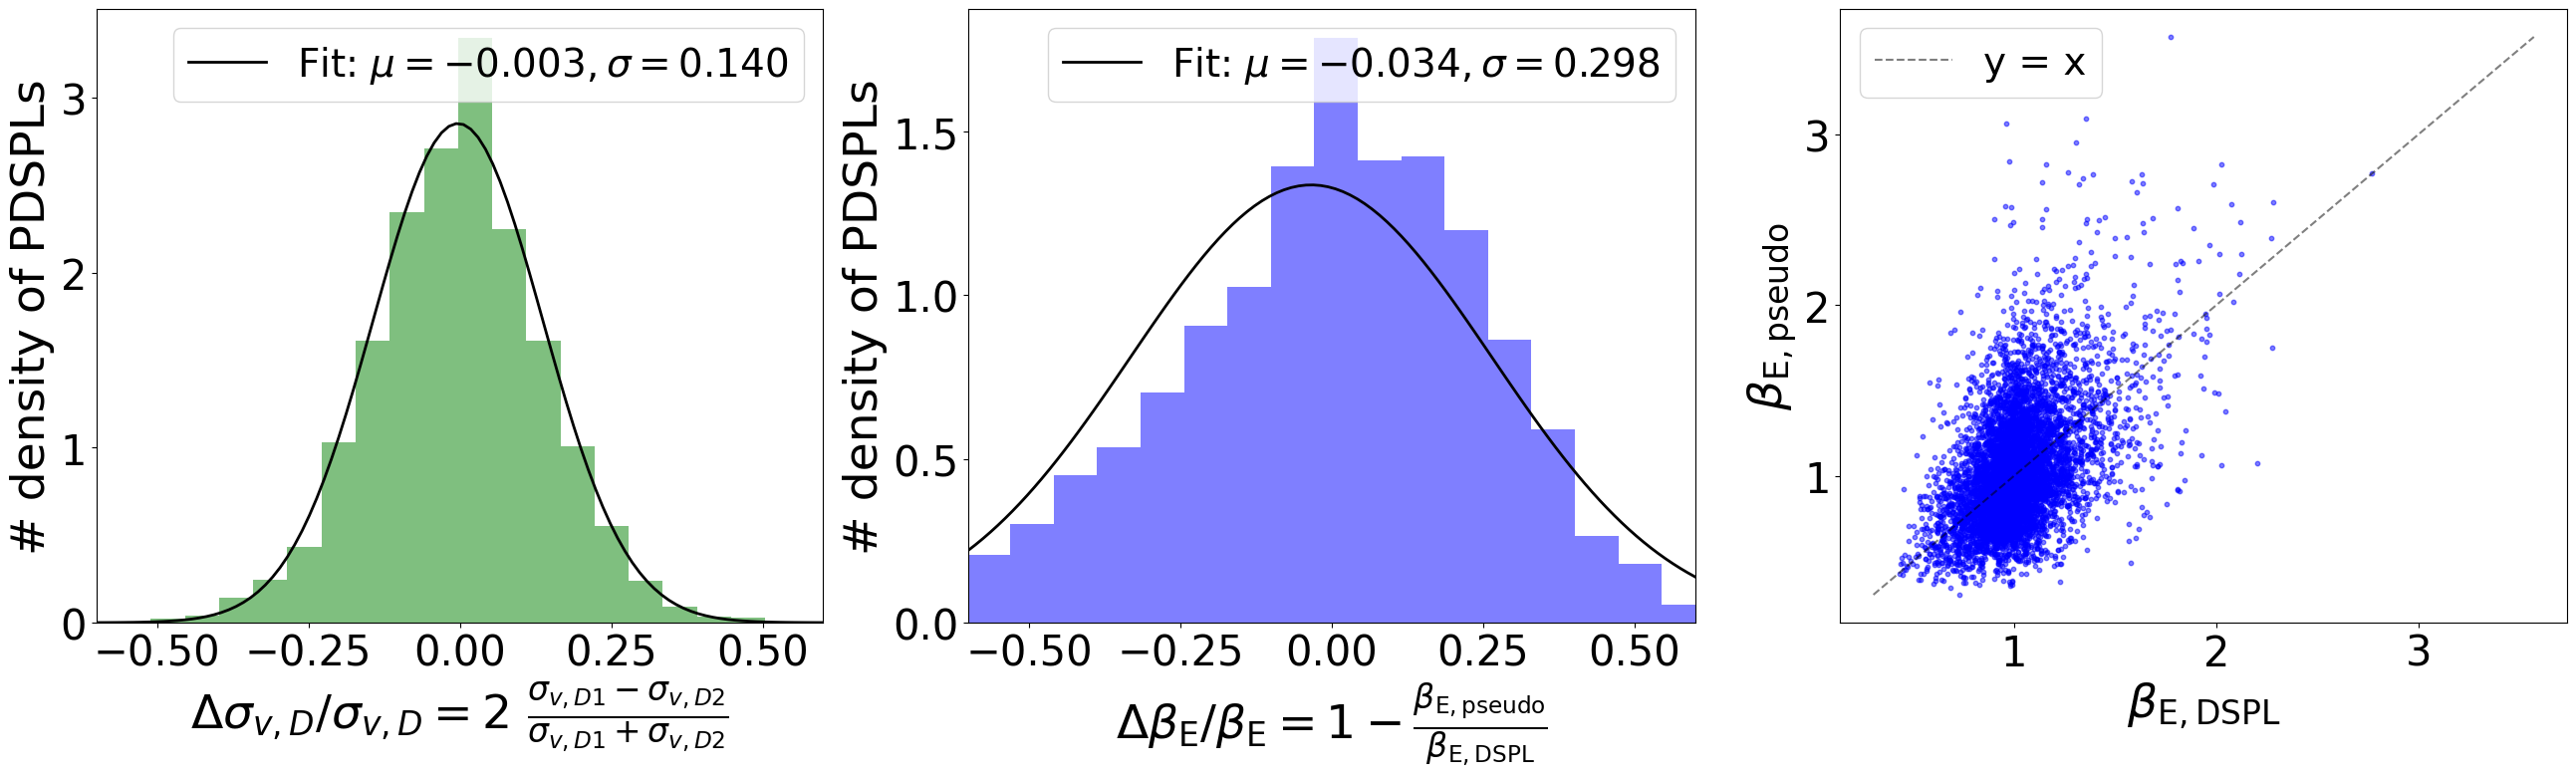

In [25]:
# histogram of the relative scatter in beta_E and sigma_v_D
fig, axs = plt.subplots(1, 3, figsize=(32, 8))

masked_paired_table = individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) <= THRESHOLD_DELTA_Z
]

# First histogram: relative scatter in sigma_v_D
axs[0].hist(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2']),
    bins=20, color='green', alpha=0.5, density=True
)
axs[0].set_xlabel(r'$\Delta \sigma_{v,D} / \sigma_{v,D} = 2 \ \frac{\sigma_{v,D1} - \sigma_{v,D2}}{\sigma_{v,D1} + \sigma_{v,D2}}$', fontsize=16)
axs[0].set_ylabel('# density of PDSPLs', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu, std = norm.fit(
    2 * (masked_paired_table['sigma_v_D1'] - masked_paired_table['sigma_v_D2']) / 
    (masked_paired_table['sigma_v_D1'] + masked_paired_table['sigma_v_D2'])
)
x = np.linspace(-0.6, 0.6, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label=f'Fit: $\\mu={mu:.3f}, \\sigma={std:.3f}$')
axs[0].legend(fontsize=14)

# Second histogram: relative scatter in beta_E
axs[1].hist(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'], bins=40, 
            color='blue', alpha=0.5, density=True)
axs[1].set_xlabel(r'$\Delta \beta_{\rm E} / \beta_{\rm E} = 1 - \frac{\beta_{\rm E,pseudo}}{\beta_{\rm E,DSPL}}$', fontsize=16)
axs[1].set_ylabel('# density of PDSPLs', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.6, 0.6)

# fit a gaussian to the histogram
mu_beta, std_beta = norm.fit(1 - masked_paired_table['beta_E_pseudo'] / masked_paired_table['beta_E_DSPL'])
x_beta = np.linspace(-0.6, 0.6, 100)
p_beta = norm.pdf(x_beta, mu_beta, std_beta)
axs[1].plot(x_beta, p_beta, 'k', linewidth=2, label=f'Fit: $\\mu={mu_beta:.3f}, \\sigma={std_beta:.3f}$')
axs[1].legend(fontsize=14)

# Third plot: beta_E_pseudo vs beta_E_DSPL
axs[2].scatter(masked_paired_table['beta_E_DSPL'], masked_paired_table['beta_E_pseudo'], 
               alpha=0.5, s=10, color='blue')
axs[2].set_xlabel(r'$\beta_{\rm E,DSPL}$', fontsize=16)
axs[2].set_ylabel(r'$\beta_{\rm E,pseudo}$', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)

# Plot y = x line
min_val = min(np.min(masked_paired_table['beta_E_DSPL']), np.min(masked_paired_table['beta_E_pseudo']))
max_val = max(np.max(masked_paired_table['beta_E_DSPL']), np.max(masked_paired_table['beta_E_pseudo']))
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y = x')
axs[2].legend(fontsize=14)


# change tick and label sizes
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.xaxis.label.set_size(34)
    ax.yaxis.label.set_size(34)
    # make title font size larger
    ax.title.set_fontsize(28)

    # legend font size
    if ax.get_legend() is not None:
        ax.legend(fontsize=28)



# fig.savefig(f"../figures/slsim_hists_sigma_v_beta_E_scatter.pdf", bbox_inches='tight', dpi=300)

In [79]:
# check magnitude cuts
# $m_u < 26, m_g < 27.4, m_r < 27.5, m_i < 26.8, m_z < 26.1, m_y < 24.9$
mask = (
    # (GGL_data_table['mag_S_u'] < 26) & 
    (GGL_data_table['mag_S_g'] < 27.4) & 
    (GGL_data_table['mag_S_r'] < 27.5) & 
    (GGL_data_table['mag_S_i'] < 26.8) & 
    (GGL_data_table['mag_S_z'] < 26.1) & 
    (GGL_data_table['mag_S_y'] < 24.9)
)

mask &= (
    # (GGL_data_table['mag_D_u'] < 26) & 
    (GGL_data_table['mag_D_g'] < 27.4) & 
    (GGL_data_table['mag_D_r'] < 27.5) & 
    (GGL_data_table['mag_D_i'] < 26.8) & 
    (GGL_data_table['mag_D_z'] < 26.1) & 
    (GGL_data_table['mag_D_y'] < 24.9)
)

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.874766281062172,3.545583064828747,0.5271512655623897,260.5978887361845,26.853258195825937,26.925494458520753,27.457930599662895,26.686583709588596,26.544720166139122,25.92318926265024,26.507824702469186,26.905931674721835,24.595022342638423,23.93346948236516,0.5797774619756767,-0.002208108153086985,0.005392911277923769,0.005827455162185858,2,4.8826461669528705,6542.855098668025,28.158590719935617
1,0.4138050696952206,3.8343999994409157,1.4393258840689025,254.05329891410793,25.64551209236478,25.688530776877375,26.278716081794247,25.491088026004245,25.417914573833546,18.520716732657142,19.171248409828237,20.74093773475746,18.179217256496216,17.989868312429635,1.247678057249737,0.006132279192749697,0.046362948498560715,0.0467667386245612,2,6.842377061519371,3383.0904062076133,23.684399870902915
2,0.32325614833622546,1.263051255692255,0.7821164871523214,200.91758583641038,23.05913286966915,23.16094579234929,23.143077146533578,22.772195739206346,22.501368399948653,18.476642206325824,19.031728576226843,20.415057196143994,18.15740576610015,17.96729603646998,0.8853398414803644,-0.02204878885825497,-0.12385023078879108,0.12579757055107513,2,4.14959152859635,2424.2058253119626,22.612022305783967
3,0.562141659276947,2.228935373955962,0.6268352573021465,187.2509190836209,26.32172970675993,26.391798005724706,26.51507877033796,26.23047250398506,26.044465790413806,20.465941368751388,21.458442825869838,22.872098464130787,20.076895394594914,19.83176447679721,0.3718393435641739,-0.23364958536235933,0.01565812010614346,0.23417366518304497,2,2.409915827920992,3088.000865920878,23.161506725191224
4,0.32961696763102005,1.8364011969163303,1.1746055885230164,235.226967710898,27.08233854845476,27.275334657725264,27.535833391621477,26.800717489346663,26.679558011978283,17.96329993252079,18.4787842754518,19.81192721189381,17.655825334177578,17.495461785609464,0.8975541164216171,-0.06691971811502932,-0.157046084220501,0.1707094644171426,2,4.2620605583452384,3160.3052913670053,22.013002413861788
5,1.1885315447926554,3.1073255592617306,0.5777091801342814,218.13052859942349,25.359687854320633,25.458911457336384,25.55357438747121,25.274512613609943,25.316853240155538,22.838022047453812,23.28921679526814,23.44175965607225,22.29643928459837,21.75708160588045,0.3852627009757341,0.07560748726390835,0.17197368728797346,0.18786016408430967,2,3.190597556438011,7201.423349682187,23.82337151452748
6,1.2440370141998318,3.760970123815943,0.8460494611952895,255.67390161839958,26.605306337160417,26.634371681949826,27.14991616134917,26.44767661651716,26.356053550173673,22.961834070119288,23.95417983437018,24.56918427670501,22.245718878420327,21.531031936475514,0.6906795913465504,0.0037815838235121923,-0.0018989305919526673,0.004231585235736461,2,5.75659122289918,5888.682565311953,26.213378895096472
7,1.2186608418866445,2.9173020967013943,0.7909399459500751,263.88597471954085,25.951824495289113,26.174535381052156,26.385565314046598,25.800195257663386,25.734022059756608,23.074782975496294,24.46612036927917,26.09137599472469,22.299809513418207,21.50800078275739,0.5735765385699269,0.06977142660841433,-0.06394371013497493,0.0946406362869515,2,4.76742377834762,6574.3099157719225,27.312897074985525
8,1.3205838348704433,3.3341757883448344,0.5647478195163559,222.16083231572213,25.194104702779097,25.34107204741434,25.727573876422294,25.047481342231574,24.93893135962986,23.698905530774027,24.50735038605537,24.7385994037762,23.179622169600314,22.403521342179367,0.4016907793891605,0.1275790419352308,0.16584650412686347,0.209240232441596,2,3.370733889796594,5373.308523883364,25.15147809628904
